In [177]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [178]:
dataset = pd.read_csv("dataset/SampleData.csv")
dataset.head(12)

,Ingredient,Product,QMerged_label,Real_Cost,V_0
0,1,1,11,10,0
1,1,2,12,6,0
2,2,1,21,8,0
3,2,2,22,11,0
4,3,1,31,3,0
5,3,2,32,7,0
6,4,1,41,8,0
7,4,2,42,5,0
8,4,3,43,1,0


In [179]:
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.layer1 = nn.Linear(state_size, 64)
        self.layer2 = nn.Linear(64,action_size)


    def forward(self, state):
        x = torch.relu(self.layer1(state))
        return self.layer2(x)
    
class MonteCarloDQN:
    def __init__(self, dataset, num_episodes, epsilon, budget, reward, alpha):
        self.state_space = list(set(dataset['Ingredient']))
        self.alpha = alpha
        self.epsilon = epsilon
        self.budget = budget
        self.reward = reward
        self.num_episodes = num_episodes
        self.q_network = DQNetwork(len(self.state_space), len(self.state_space))
        self.target_network = DQNetwork(len(self.state_space), len(self.state_space))
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=alpha)
        self.criterion = nn.MSELoss()

    def run(self, dataset):
        v0 = dataset['V_0']
        dataset['V'] = v0
        output = []
        output1 = []
        output2 = []
        action_in_full = []

        for episode in range(self.num_episodes):
            if episode == 0:
                episode_run = np.random.randint(low=1, high=len(self.state_space) + 1, size=len(self.state_space))
                print(f'Episode Run: {episode_run}')
            else:
                state = torch.Tensor(np.zeros(len(self.state_space)))  # Initial state is all zeros
                episode_run = []
                for t in range(len(self.state_space)):
                    if random.random() < self.epsilon:
                        action = random.randint(0, len(self.state_space) - 1)
                    else:
                        q_values = self.q_network.forward(state.unsqueeze(0))
                        action = torch.argmax(q_values).item()
                    episode_run.append(action)
                    next_state = torch.Tensor(np.zeros(len(self.state_space)))  # Next state is all zeros

                    merged_label = (self.state_space[t] * 10 + action).astype(float)
                    merged_rewards = dataset[dataset['QMerged_label'] == merged_label]['Reward']
                    reward = self.reward if merged_rewards.empty else merged_rewards.iloc[0]

                    # reward calculation
                    if self.budget >= dataset[dataset['QMerged_label'] == merged_label]['Real_Cost'].sum():
                        terminal_reward = 1
                    else:
                        terminal_reward = -1

                    q_values = self.q_network.forward(state.unsqueeze(0))
                    next_q_values = self.target_network.forward(next_state.unsqueeze(0))
                    target = q_values.clone()
                    target[0, action] = reward + self.alpha * torch.max(next_q_values)

                    self.optimizer.zero_grad()
                    loss = self.criterion(q_values, target.detach())
                    loss.backward()
                    self.optimizer.step()

                    state = next_state

            episode_df = pd.DataFrame({'Ingredient': self.state_space, 'Product': episode_run})
            episode_df['Merged_label'] = (episode_df['Ingredient'] * 10 + episode_df['Product']).astype(float)
            dataset['QMerged_label'] = dataset['QMerged_label'].astype(float)
            dataset['Reward'] = self.reward

            episode2 = episode_df.merge(dataset[['QMerged_label', 'Real_Cost', 'Reward']],
                                        left_on='Merged_label', right_on='QMerged_label', how='inner')

            dataset = dataset.drop(columns='Reward')

            if self.budget >= episode2['Real_Cost'].sum():
                return_value = 1
            else:
                return_value = -1

            episode2 = episode2.drop(columns='Reward')
            episode2['Return'] = return_value
            dataset = dataset.merge(episode2[['Merged_label', 'Return']], left_on='QMerged_label',
                                    right_on='Merged_label', how='outer')
            dataset['Return'] = dataset['Return'].fillna(0)

            for v in range(len(dataset)):
                if dataset.iloc[v, 7] == 0:
                    dataset.iloc[v, 5] = dataset.iloc[v, 5]
                else:
                    dataset.iloc[v, 5] = dataset.iloc[v, 5] + self.alpha * (
                            (dataset.iloc[v, 7] / len(self.state_space)) - dataset.iloc[v, 5])

            dataset = dataset.drop(columns='Merged_label')
            dataset = dataset.drop(columns='Return')

            output = np.append(output, dataset.iloc[:, -1].sum())
            output1 = np.append(output1, dataset.iloc[[1, 2, 4, 8], -1].sum())
            output2 = np.append(output2, dataset.iloc[[0, 3, 5, 6, 7], -1].sum())

            action = pd.DataFrame(dataset.groupby('Ingredient')['V'].max())
            action2 = action.merge(dataset, left_on='V', right_on='V', how='inner')
            action3 = action2.groupby('Ingredient')['Product'].apply(
                lambda x: x.iloc[np.random.randint(0, len(x))])

            action_in_full = np.append(action_in_full, action3)
            action_in_full = action_in_full.astype(int)

        return output, output1, output2, action3, dataset, action_in_full


In [180]:
alpha = 0.1
epsilon = 0.1
budget = 100
reward = [0,0,0,0,0,0,0,0,0]
num_episodes = 100

monte_carlo = MonteCarlo(dataset, num_episodes, epsilon, budget, reward, alpha)
# Run Monte Carlo simulation
output, output1, output2, optimal_actions, updated_data, actions_selected_in_time = monte_carlo.run(dataset)

# Print the results
print("Sum of V(a) for all episodes:", output)
print("Sum of V(a) for the cheapest actions:", output1)
print("Sum of V(a) for the rest of the actions:", output2)
print("Optimal actions:", optimal_actions)
print("Updated dataset:", updated_data)
print("Actions selected in each episode:", actions_selected_in_time)

Episode Run: [2 1 3 1]


Sum of V(a) for all episodes: [0.075      0.1675     0.25075    0.325675   0.3931075  0.45379675
 0.50841708 0.55757537 0.60181783 0.64163605 0.67747244 0.7097252
 0.73875268 0.76487741 0.78838967 0.8095507  0.82859563 0.84573607
 0.86116246 0.87504622 0.88754159 0.92105196 0.93144676 0.94080209
 0.94922188 0.98000495 0.98700445 0.99330401 0.99897361 1.02526788
 1.04893272 1.05331445 1.057258   1.0608072  1.06400148 1.06687633
 1.0694637  1.07179233 1.0738881  1.07577429 1.07747186 1.07899967
 1.08037471 1.08161224 1.08272601 1.08372841 1.10691237 1.10774613
 1.12855014 1.12924513 1.12987061 1.13043355 1.1309402  1.14949233
 1.16618926 1.16658308 1.16693752 1.18191441 1.18221194 1.18247972
 1.18272072 1.18293763 1.18313284 1.18330853 1.18346665 1.18360896
 1.19697814 1.1970979  1.20912268 1.22742486 1.22751819 1.22760219
 1.22767779 1.22774583 1.22780707 1.22786218 1.22791178 1.22795643
 1.2279966  1.22803276 1.22806531 1.22809459 1.22812095 1.22814468
 1.22816603 1.22818525 1.22820254

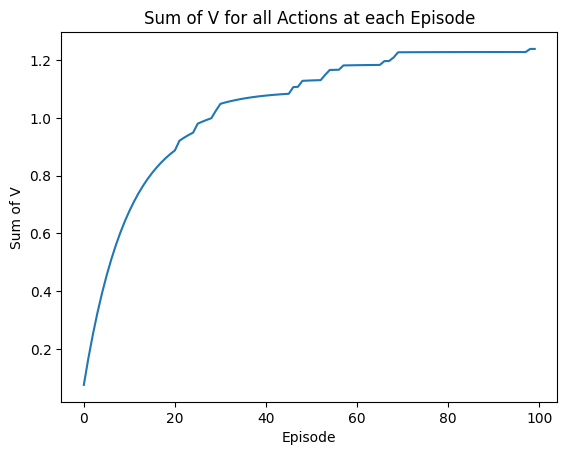

In [181]:
import matplotlib.pyplot as plt

plt.plot(range(0,num_episodes), output)
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()

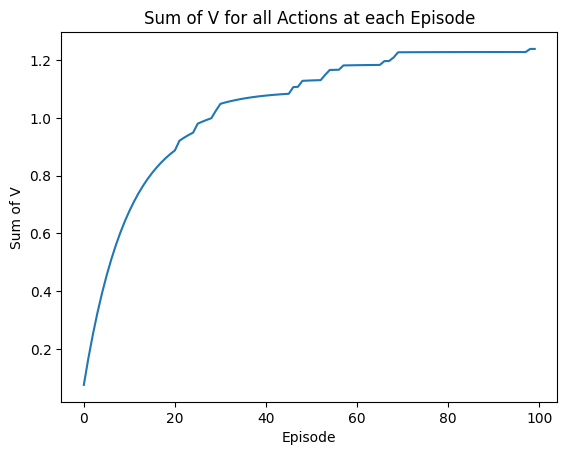

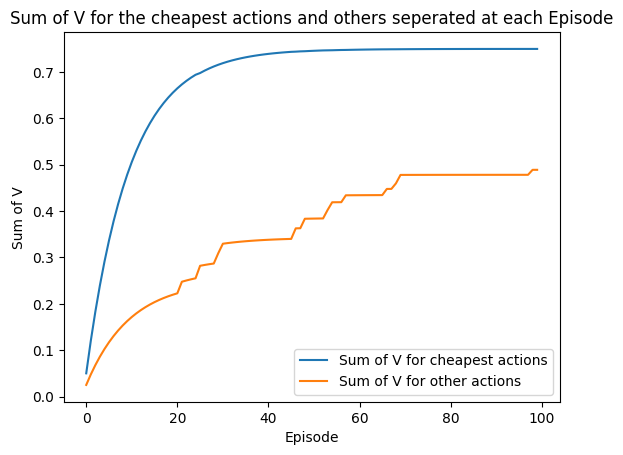

In [188]:
plt.plot(range(0,num_episodes), output)
plt.title('Sum of V for all Actions at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.show()



plt.plot(range(0, num_episodes), output1, label='Sum of V for cheapest actions')
plt.plot(range(0, num_episodes), output2, label='Sum of V for other actions')

plt.title('Sum of V for the cheapest actions and others seperated at each Episode')
plt.xlabel('Episode')
plt.ylabel('Sum of V')
plt.legend(loc="lower right")
plt.show()